In [1]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
# 폴더 생성
if not any([s=='result' for s in os.listdir('.')]):
    os.mkdir('result')
    
if not any([s=='img' for s in os.listdir('.')]):
    os.mkdir('img')

In [3]:
def get_oil_price(code):
    
    """
        Description
        -----------
        유가 데이터 수집 프로그램(from 네이버)
        
        Input
        -----
        code : OIL_CL(WTI), OIL_DU(두바이유), OIL_LO(경유), ...
        
        Output
        ------
        일별 유가(종가)
        
        Example
        -------
        oil_price_du = get_oil_price('OIL_DU')
        
    """
    
    delay = 0.01
    page = 1
    result = []
    start_time = datetime.now()
    
    # 수집
    print('[{}] 데이터 수집을 시작합니다. (code: {})'.format(start_time.strftime('%Y/%m/%d %H:%M:%S'), code))
    while(True):
        url = 'https://finance.naver.com/marketindex/worldDailyQuote.nhn?marketindexCd={}&fdtc=2&page={}'.format(code, page)
        data = pd.read_html(url)[0].dropna()
        if page != 1:
            try:
                if data.iloc[-1, 0] == result[-1].iloc[-1, 0]:
                    break
            except:
                break
        result.append(data)
        page += 1
        time.sleep(delay)
    
    # 가공
    oil_price = pd.concat(result).reset_index(drop=True)
    oil_price.columns = ['날짜', '종가', '전일대비', '등락율']
    oil_price['날짜'] = oil_price['날짜'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d'))
    oil_price = oil_price[['날짜', '종가']]
    oil_price.insert(0, '코드', code)
    
    end_time = datetime.now()
    print('[{}] 데이터 수집을 종료합니다. (code: {}, 수집시간: {}초, 데이터수: {:,}개)'.format(end_time.strftime('%Y/%m/%d %H:%M:%S'), code, (end_time-start_time).seconds, len(oil_price)))
    return oil_price

In [4]:
oil_price_du = get_oil_price('OIL_DU')
oil_price_wti = get_oil_price('OIL_CL')
oil_price_brent = get_oil_price('OIL_BRT')

[2023/05/12 11:36:44] 데이터 수집을 시작합니다. (code: OIL_DU)
[2023/05/12 11:37:21] 데이터 수집을 종료합니다. (code: OIL_DU, 수집시간: 37초, 데이터수: 4,242개)
[2023/05/12 11:37:21] 데이터 수집을 시작합니다. (code: OIL_CL)
[2023/05/12 11:37:57] 데이터 수집을 종료합니다. (code: OIL_CL, 수집시간: 35초, 데이터수: 4,086개)
[2023/05/12 11:37:57] 데이터 수집을 시작합니다. (code: OIL_BRT)
[2023/05/12 11:38:33] 데이터 수집을 종료합니다. (code: OIL_BRT, 수집시간: 35초, 데이터수: 4,142개)


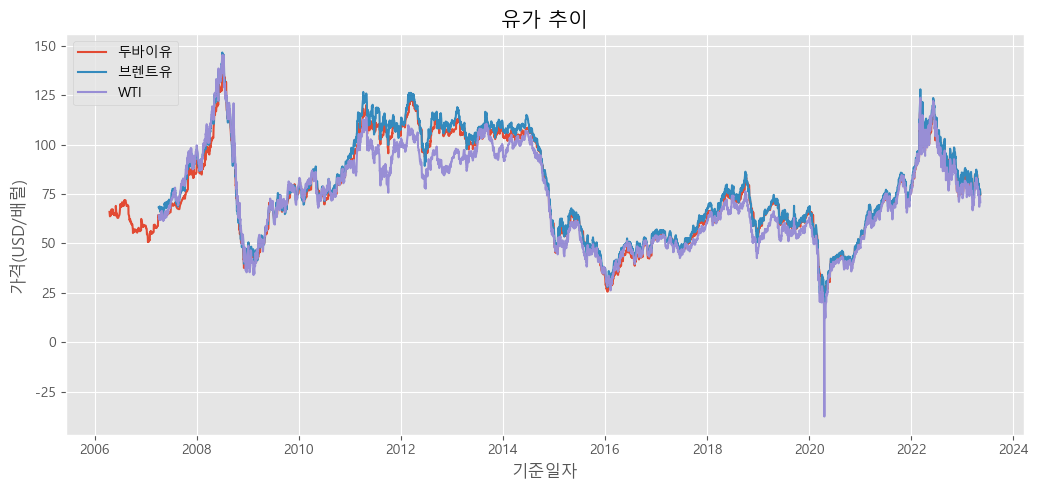

In [5]:
# 시각화
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10.5,5))
plt.plot(oil_price_du['날짜'], oil_price_du['종가'], label='두바이유')
plt.plot(oil_price_brent['날짜'], oil_price_brent['종가'], label='브렌트유')
plt.plot(oil_price_wti['날짜'], oil_price_wti['종가'], label='WTI')

plt.title('유가 추이')
plt.xlabel('기준일자')
plt.ylabel('가격(USD/배럴)')
plt.legend()
plt.tight_layout()
plt.savefig('img/유가 추이')
plt.show()

In [6]:
now = datetime.now().strftime('%Y%m%d%H%M%S')
with pd.ExcelWriter('result/oil_price_{}.xlsx'.format(now), 'xlsxwriter') as writer:
    oil_price_du.to_excel(writer, '두바이유', index=False)
    oil_price_brent.to_excel(writer, '브렌트유', index=False)
    oil_price_wti.to_excel(writer, 'WTI', index=False)